In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from typing import List
from collections import defaultdict

from scipy import stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


In [2]:
def generate_data_with_correlation(
    size: int,
    ate: float,
    pre_corr: float,
    exp_corr: float,
    y_before_corr: float,
    x_corr: List[float],
    seed: int = None
) -> pd.DataFrame:
    """"""
    
    if seed is not None:
        np.random.seed(seed)
    
    X = np.random.multivariate_normal(
        mean=[0, 0, 0], 
        cov=[[1, pre_corr, pre_corr], 
        [pre_corr, 1, pre_corr], 
        [pre_corr, pre_corr, 1]], 
        size=size
    )
    
    X1, X2, X3 = X[:, 0], X[:, 1], X[:, 2]

    T = np.random.binomial(n=1, p=0.5, size=size)
    
    Y_before = np.random.normal(0, 1, size)

#     Y_before = x_corr[0] * X1 + x_corr[1] * X2 + x_corr[2] * X3 #+ np.random.normal(0, 0.1, size)

    W_group_0 = np.random.multivariate_normal(
        mean=[0, 0, 0], 
        cov=[[1, exp_corr, exp_corr], 
        [exp_corr, 1, exp_corr], 
        [exp_corr, exp_corr, 1]], 
        size=size // 2
    )
    
    W_group_1 = np.random.multivariate_normal(
        mean=[0.1, -0.1, 0.2], 
        cov=[[1, exp_corr, exp_corr], 
        [exp_corr, 1, exp_corr], 
        [exp_corr, exp_corr, 1]], 
        size=size // 2
    )

    W = np.vstack((W_group_0, W_group_1))

    np.random.shuffle(W)

    W1, W2, W3 = W[:, 0], W[:, 1], W[:, 2]

    Y = Y_before * y_before_corr + T * ate + 0.4 * W1 + 0.3 * W2 + 0.3 * W3 + x_corr[0] * X1 + x_corr[1] * X2 + x_corr[2] * X3

    group_0_W = W[T == 0]
    group_1_W = W[T == 1]

#     for i in range(3):
#         stat, p_value = ttest_ind(group_0_W[:, i], group_1_W[:, i])
#         if p_value < 0.05:
#             print(f"Statistically significant difference found in W{i+1}: p-value = {p_value:.4f}")

    data = pd.DataFrame({
        "Y": Y,
        "Y_before": Y_before,
        "T": T,
        "X1": X1,
        "X2": X2,
        "X3": X3,
        "W1": W1,
        "W2": W2,
        "W3": W3
    })

    return data


https://habr.com/ru/companies/X5Tech/articles/780270/

In [3]:
def calculate_theta(metrics: pd.Series, covariates: pd.Series) -> float:
    """"""
    covariance = np.cov(covariates, metrics)[0, 1]
    variance = covariates.var()
    theta = covariance / variance
    
    return theta


def check_ttest(df_control: pd.DataFrame, df_pilot: pd.DataFrame) -> float:
    """"""
    
    values_control = df_control["Y"].values
    values_pilot = df_pilot["Y"].values
    _, pvalue = stats.ttest_ind(values_control, values_pilot)
    
    return pvalue

def check_cuped(df_control: pd.DataFrame, df_pilot: pd.DataFrame, covariate: str) -> float:
    """"""
    
    df_theta = pd.concat([df_control, df_pilot])
    
    theta = calculate_theta(df_theta["Y"], df_theta[covariate])
    metric_cuped_control = df_control["Y"] - theta * df_control[covariate]
    metric_cuped_pilot = df_pilot["Y"] - theta * df_pilot[covariate]
    _, pvalue = stats.ttest_ind(metric_cuped_control, metric_cuped_pilot)
    
    return pvalue


def get_predict_cupac(df_control: pd.DataFrame, df_pilot: pd.DataFrame, covariates: List[str]) -> float:
    """"""
    df = pd.concat([df_control, df_pilot])
    
    X = df[covariates]
    y = df["Y"]
    
    model = LinearRegression()
    model.fit(X, y) # Here, in fact, it is CUNOPAC because we train on the entire sample
    
    # But since we are using a linear model, this is acceptable. 
    
    df["pred"] = model.predict(X)
    
    return df
    


def check_cupac(df_control: pd.DataFrame, df_pilot: pd.DataFrame, covariates: List[str]) -> float:
    """"""
    predict_df = get_predict_cupac(df_control, df_pilot, covariates)
    
    df_control = predict_df[predict_df["T"] == 0]
    df_pilot = predict_df[predict_df["T"] == 1]
    
    theta = calculate_theta(predict_df["Y"], predict_df["pred"])
    
    metric_cuped_control = df_control["Y"] - theta * df_control["pred"]
    metric_cuped_pilot = df_pilot["Y"] - theta * df_pilot["pred"]

    _, pvalue = stats.ttest_ind(metric_cuped_control, metric_cuped_pilot)
    
    
    return pvalue



def check_improved_cupac(
    df_control: pd.DataFrame,
    df_pilot: pd.DataFrame,
    pre_experiment_covariates: List[str],
    in_experiment_covariates: List[str]
) -> float:
    """"""
    
    df = pd.concat([df_control, df_pilot])
    
    model_cuped = LinearRegression()
    model_cuped.fit(df[pre_experiment_covariates], df['Y'])
    df["Y_pred"] = model_cuped.predict(df[pre_experiment_covariates])

    df["R"] = df["Y"] - df["Y_pred"]

    model_cupac = LinearRegression()
    model_cupac.fit(df[in_experiment_covariates], df["R"])
    gamma_hat = model_cupac.coef_
    
    df["R_adj"] = df["R"] - df[in_experiment_covariates].dot(gamma_hat)
    
    df_control = df[df["T"] == 0]
    df_pilot = df[df["T"] == 1]

    _, pvalue = stats.ttest_ind(df_control["R_adj"], df_pilot["R_adj"])

    
    return pvalue


def plot_pvalue_distribution(dict_pvalues: dict) -> None:
    """"""
    X = np.linspace(0, 1, 1000)
    
    for key, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, label=key)
    
    plt.plot([0, 1], [0, 1], "--k", alpha=0.8)
    plt.title("p-value distribution", size=16)
    plt.xlabel("p-value", size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()
    
    return


Let's generate a dataset

In [4]:
data = generate_data_with_correlation(
        size=10000, # sample size
        ate=0.01, # added effect size
        pre_corr=0.5,
        exp_corr=0.3,
        y_before_corr=0.2, # correlations of Y_before with the outcome variable
        x_corr=[0.4, 0.3, 0.1], # correlations of X with the outcome variable
        seed=111,
    )

In [5]:
data.corr()

,Y,Y_before,T,X1,X2,X3,W1,W2,W3
Y,1.000000,0.201579,0.005033,0.591332,0.549372,0.457912,0.580045,0.478549,0.491935
Y_before,0.201579,1.000000,-0.008648,0.019907,0.006370,0.002806,0.001793,-0.027244,-0.002823
T,0.005033,-0.008648,1.000000,0.002118,-0.002585,-0.009397,-0.001446,0.002203,0.008713
X1,0.591332,0.019907,0.002118,1.000000,0.502692,0.518442,0.007236,-0.027486,-0.014263
X2,0.549372,0.006370,-0.002585,0.502692,1.000000,0.506150,0.017725,-0.017321,-0.005307
X3,0.457912,0.002806,-0.009397,0.518442,0.506150,1.000000,0.005371,-0.000149,-0.000251
W1,0.580045,0.001793,-0.001446,0.007236,0.017725,0.005371,1.000000,0.299065,0.300001
W2,0.478549,-0.027244,0.002203,-0.027486,-0.017321,-0.000149,0.299065,1.000000,0.286075
W3,0.491935,-0.002823,0.008713,-0.014263,-0.005307,-0.000251,0.300001,0.286075,1.000000


In [6]:
df_control = data[data["T"] == 0]
df_pilot = data[data["T"] == 1]

In [7]:
check_ttest(df_control, df_pilot)

0.6147762932764005

In [8]:
check_cuped(df_control, df_pilot, "Y_before")

0.4890794449705197

In [9]:
check_cupac(df_control, df_pilot, ["Y_before", "X1", "X2", "X3"])

0.28759664869658025

In [10]:
check_improved_cupac(df_control, df_pilot, ["Y_before", "X1", "X2", "X3"], ["W1"])

0.054288452829773404

In [11]:
check_improved_cupac(df_control, df_pilot, ["Y_before", "X1", "X2", "X3"], ["W1", "W2"])

0.006344707372710133

We observe that if the within-experiment covariates have a higher correlation with the outcome variable, then the improved CUPAC yields a greater reduction in variance

In [12]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    """"""
    
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    
    return mde


In [13]:
get_minimal_determinable_effect(
    df_control["Y"].std(),
    5000
)

0.05587236326084488

A/A test

100%|███████████████████████████████████████| 5000/5000 [04:23<00:00, 18.94it/s]


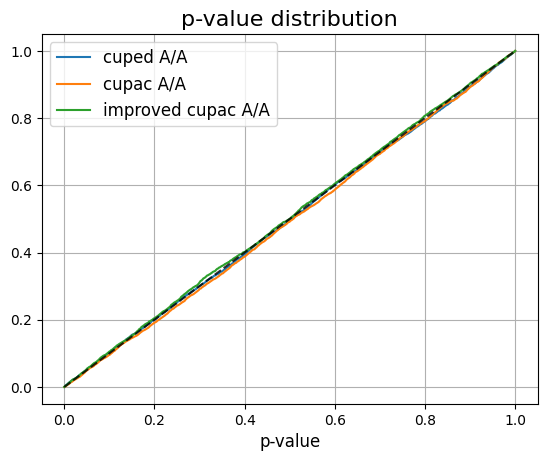

In [14]:

dict_pvalues = defaultdict(list)

for _ in tqdm(range(5000)):
    data = generate_data_with_correlation(
        size=5000,
        ate=0.01,
        pre_corr=0.5,
        exp_corr=0.3,
        y_before_corr=0.3,
        x_corr=[0.3, 0.3, 0.1],
    )
    
    df_control = data[data["T"] == 0]
    df_pilot = data[data["T"] == 1]

#     dict_pvalues['cuped A/B'].append(check_cuped(df_control, df_pilot))
    dict_pvalues["cuped A/A"].append(
        check_cuped(
        generate_data_with_correlation(
            size=5000,
            ate=0,
            pre_corr=0.5,
            exp_corr=0.3,
            y_before_corr=0.3,
            x_corr=[0.3, 0.3, 0.1],
        ),
        generate_data_with_correlation(
            size=5000,
            ate=0,
            pre_corr=0.5,
            exp_corr=0.3,
            y_before_corr=0.3,
            x_corr=[0.3, 0.3, 0.1],
        ),
        "Y_before"
        )
    )
    dict_pvalues["cupac A/A"].append(
        check_cupac(
        generate_data_with_correlation(
            size=5000,
            ate=0,
            pre_corr=0.5,
            exp_corr=0.3,
            y_before_corr=0.3,
            x_corr=[0.3, 0.3, 0.1],
        ),
        generate_data_with_correlation(
            size=5000,
            ate=0,
            pre_corr=0.5,
            exp_corr=0.3,
            y_before_corr=0.3,
            x_corr=[0.3, 0.3, 0.1],
        ),
        ["Y_before", "X1", "X2", "X3"]
        )
    )
    dict_pvalues["improved cupac A/A"].append(
        check_improved_cupac(
        generate_data_with_correlation(
            size=5000,
            ate=0,
            pre_corr=0.5,
            exp_corr=0.3,
            y_before_corr=0.3,
            x_corr=[0.3, 0.3, 0.1],
        ),
        generate_data_with_correlation(
            size=5000,
            ate=0,
            pre_corr=0.5,
            exp_corr=0.3,
            y_before_corr=0.3,
            x_corr=[0.3, 0.3, 0.1],
        ),
        ["Y_before", "X1", "X2", "X3"],
        ["W1"]
        )
    )
#     dict_pvalues['cupac A/B'].append(check_cupac(df_control, df_pilot, ["Y_before", "X1", "X2", "X3"]))
#     dict_pvalues['ttest A/B'].append(check_ttest(df_control, df_pilot))
#     dict_pvalues['improved cupac A/B'].append(check_improved_cupac(df_control, df_pilot, ["Y_before", "X1", "X2", "X3"], ["W1"]))

plot_pvalue_distribution(dict_pvalues)

A/B test

100%|███████████████████████████████████████| 3000/3000 [00:49<00:00, 60.47it/s]


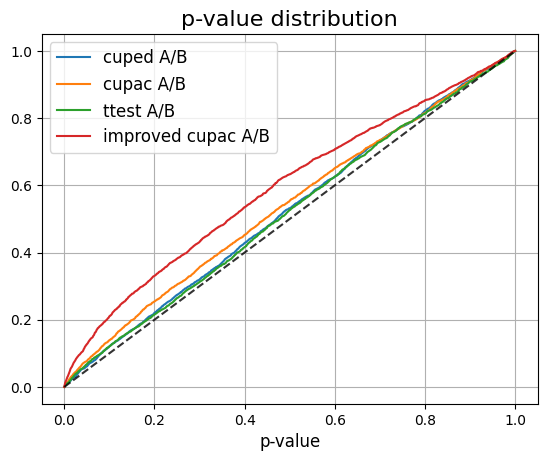

In [15]:
dict_pvalues = defaultdict(list)

for _ in tqdm(range(3000)):
    data = generate_data_with_correlation(
        size=5000,
        ate=0.01,
        pre_corr=0.5,
        exp_corr=0.3,
        y_before_corr=0.3,
        x_corr=[0.3, 0.3, 0.1],
    )
    
    df_control = data[data["T"] == 0]
    df_pilot = data[data["T"] == 1]

    dict_pvalues["cuped A/B"].append(check_cuped(df_control, df_pilot, "Y_before"))
    dict_pvalues["cupac A/B"].append(check_cupac(df_control, df_pilot, ["Y_before", "X1", "X2", "X3"]))
    dict_pvalues["ttest A/B"].append(check_ttest(df_control, df_pilot))
    dict_pvalues["improved cupac A/B"].append(check_improved_cupac(df_control, df_pilot, ["Y_before", "X1", "X2", "X3"], ["W1"]))

plot_pvalue_distribution(dict_pvalues)

In [16]:
# dict_pvalues = defaultdict(list)

# for _ in tqdm(range(1000)):
#     data = generate_data_with_correlation(
#         size=10000,
#         ate=0.015,
#         pre_corr=0.9,
#         exp_corr=0.1,
#         y_before_corr=0.01,
#         x_corr=[0.9, 0.9, 0.8]
#     )
    
#     df_control = data[data["T"] == 0]
#     df_pilot = data[data["T"] == 1]

#     dict_pvalues["cuped A/B"].append(check_cuped(df_control, df_pilot))
#     dict_pvalues["cupac A/B"].append(check_cupac(df_control, df_pilot, ["Y_before", "X1", "X2", "X3"]))
#     dict_pvalues["ttest A/B"].append(check_ttest(df_control, df_pilot))
#     dict_pvalues["improved cupac A/B"].append(check_improved_cupac(df_control, df_pilot, ["Y_before", "X1", "X2", "X3"], ["W1"]))

# plot_pvalue_distribution(dict_pvalues)

If the residuals of a model trained on pre-experimental covariates are correlated with the within-experimental variables, we obtain an increase in the proportion of reduced variance